In [74]:
## pip install lightgbm

In [75]:
## pip install catboost

In [76]:
## pip install ipywidgets

In [77]:
# pip install xgboost

In [78]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import xgboost
from xgboost import XGBRegressor

In [79]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')

In [80]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [82]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)', '강수량(mm)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})

In [83]:
# 결측치 처리
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['건물번호']
                date = df.loc[i,:]['일시'][:8]
                avg_value = df[(df['건물번호'] == building_num) & (df['일시'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

fill_missing_with_avg(train_df, '풍속')
fill_missing_with_avg(train_df, '습도')

In [84]:
## 일시 columns
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day
train_df['요일'] = train_df['일시'].dt.weekday
train_df['시간'] = train_df['일시'].dt.hour
train_df['날짜'] = train_df['일시'].dt.date

train_df['sin_요일'] = np.sin(2*np.pi*(train_df['요일'])/6)
train_df['cos_요일'] = np.cos(2*np.pi*(train_df['요일'])/6)
train_df['sin_시간'] = np.sin(2*np.pi*(train_df['시간'])/23)
train_df['cos_시간'] = np.cos(2*np.pi*(train_df['시간'])/23)
train_df['sin_일'] = np.sin(2*np.pi*(train_df['일']-1)/30)
train_df['cos_일'] = np.cos(2*np.pi*(train_df['일']-1)/30)

train_df['휴일'] = train_df['요일'].isin([5,6]).astype(int)
train_df.loc[(train_df['월'] == 6) & (train_df['일'] == 6), '휴일'] = 1
train_df.loc[(train_df['월'] == 8) & (train_df['일'] == 15), '휴일'] = 1

In [85]:
cat_month = pd.get_dummies(train_df['월'])
train_df = pd.concat([train_df, cat_month], axis = 1).drop(columns = ['월'])

In [86]:
# 건물별, 요일별, 시간별 발전량 평균 넣어주기
weekday_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['요일별_평균'] = train_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:35<00:00, 2146.71it/s]


In [87]:
# 건물별 시간, 요일별 발전량 표준편차 넣어주기
weekday_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['요일별_표준편차'] = train_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:34<00:00, 2155.33it/s]


In [88]:
# 건물별 시간별 발전량 평균 넣어주기
hour_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['시간별_평균'] = train_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:04<00:00, 3178.26it/s]


In [89]:
# 건물별 시간별 발전량 표준편차 넣어주기
hour_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['시간별_표준편차'] = train_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

  0%|          | 0/204000 [00:00<?, ?it/s]

100%|██████████| 204000/204000 [01:02<00:00, 3281.32it/s]


In [90]:
# 파생변수 생성 - 열지수
train_df['기온(F)'] = (train_df['기온'] * 9/5) + 32
T = train_df['기온(F)']
RH = train_df['습도']
train_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
# train_df['열지수'] = pd.cut(train_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])


(array([ 4423., 14707., 33221., 52404., 41295., 31996., 17516.,  7126.,
         1155.,   157.]),
 array([ 55.63234398,  61.99087681,  68.34940963,  74.70794245,
         81.06647528,  87.4250081 ,  93.78354092, 100.14207375,
        106.50060657, 112.8591394 , 119.21767222]),
 <BarContainer object of 10 artists>)

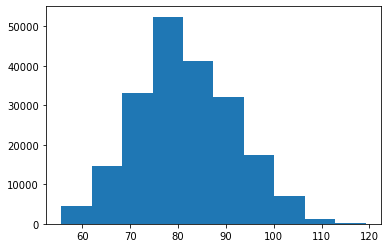

In [91]:
plt.hist(train_df['열지수'])

In [92]:
# 파생변수 생성 - 체감온도
T = train_df['기온']
W = train_df['풍속']
train_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

(array([   87.,  1681.,  8468., 13566., 36720., 62772., 50259., 23416.,
         6608.,   423.]),
 array([11.66635676, 14.52956944, 17.39278212, 20.25599479, 23.11920747,
        25.98242015, 28.84563283, 31.70884551, 34.57205818, 37.43527086,
        40.29848354]),
 <BarContainer object of 10 artists>)

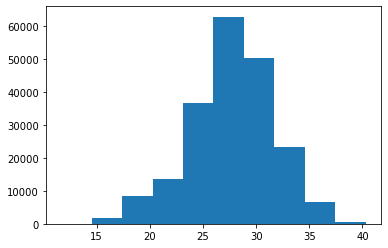

In [93]:
plt.hist(train_df['체감온도'])

In [94]:
# 파생변수 생성 - 불쾌지수
T = 9/5*train_df['기온']
RH = train_df['습도']
train_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
# train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])

(array([5.1000e+01, 4.8900e+02, 3.2690e+03, 1.0020e+04, 1.2694e+04,
        2.7965e+04, 5.2556e+04, 6.1333e+04, 3.1922e+04, 3.7010e+03]),
 array([50.48107 , 54.211942, 57.942814, 61.673686, 65.404558, 69.13543 ,
        72.866302, 76.597174, 80.328046, 84.058918, 87.78979 ]),
 <BarContainer object of 10 artists>)

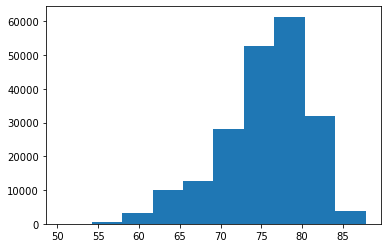

In [95]:
plt.hist(train_df['불쾌지수'])

In [96]:
# 파생변수 생성 - CDH
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [97]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

(array([  113.,  1349.,  8264., 12984., 31299., 62308., 51474., 27437.,
         8151.,   621.]),
 array([10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. , 31.7, 34.4, 37.1]),
 <BarContainer object of 10 artists>)

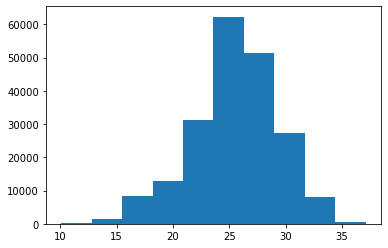

In [98]:
plt.hist(train_df['CDH'])

In [99]:
# 이상치 제거 -> 안하는게 나음
def detect_outliers(df,ratio): 
    outlier_indices = [] 
    Q1 = np.percentile(df, 25) 
    Q3 = np.percentile(df, 75) 
    IQR = Q3 - Q1 
    outlier_step = ratio * IQR 
    return ~(df < Q1 - outlier_step) | (df > Q3 + outlier_step)

# for i in range(100):    
#     idx = detect_outliers(train_target[i],1.25)
#     train_target[i] = train_target[i][idx]
#     train_input[i] = train_input[i][idx]


In [100]:
train_df.columns

Index([    '건물번호',       '일시',       '기온',       '풍속',       '습도',    '전력소비량',
              '일',       '요일',       '시간',       '날짜',   'sin_요일',   'cos_요일',
         'sin_시간',   'cos_시간',    'sin_일',    'cos_일',       '휴일',          6,
                7,          8,   '요일별_평균', '요일별_표준편차',   '시간별_평균', '시간별_표준편차',
          '기온(F)',      '열지수',     '체감온도',     '불쾌지수',      'CDH'],
      dtype='object')

In [101]:
train_df = train_df.drop(columns = ['일시', '요일', '시간', '기온(F)'])

c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 53132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48520 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 53132 missing from current font.
  font.set_text(s, 0, flags=flags)


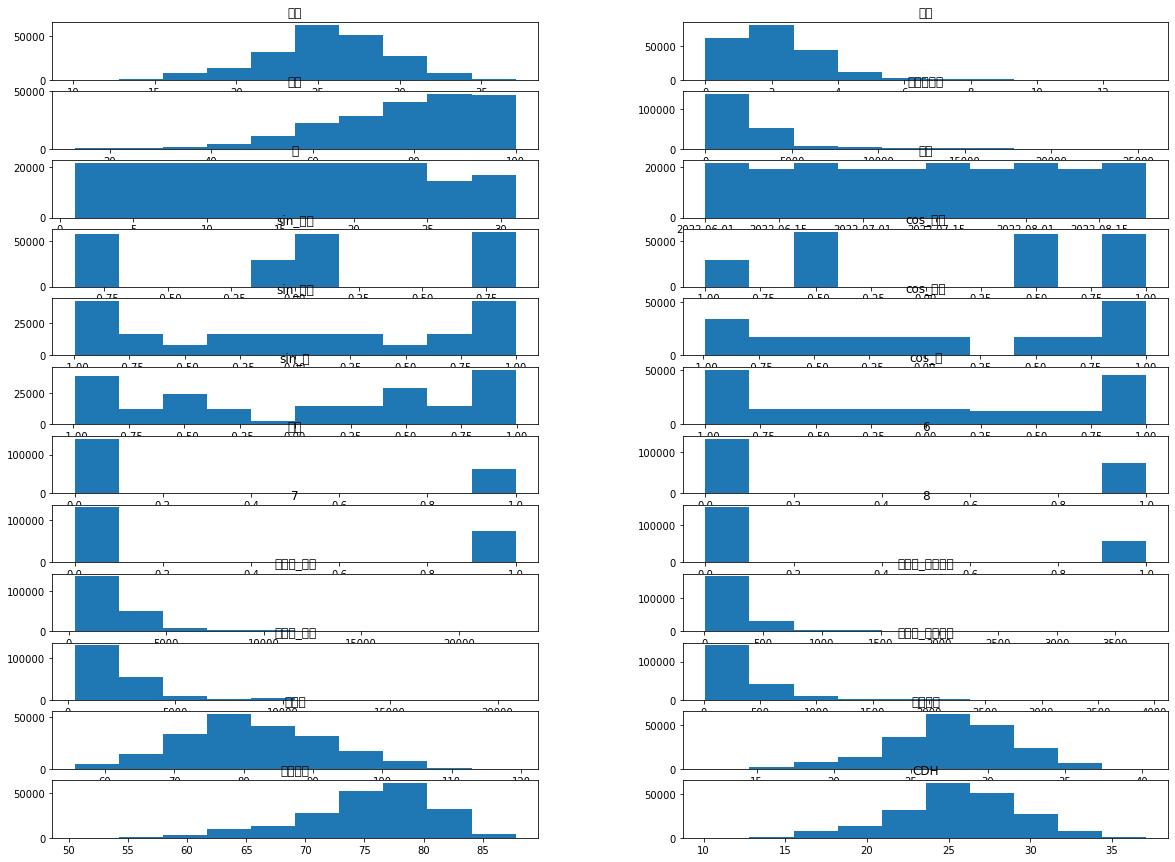

In [103]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(12,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(train_df.columns[1:]):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

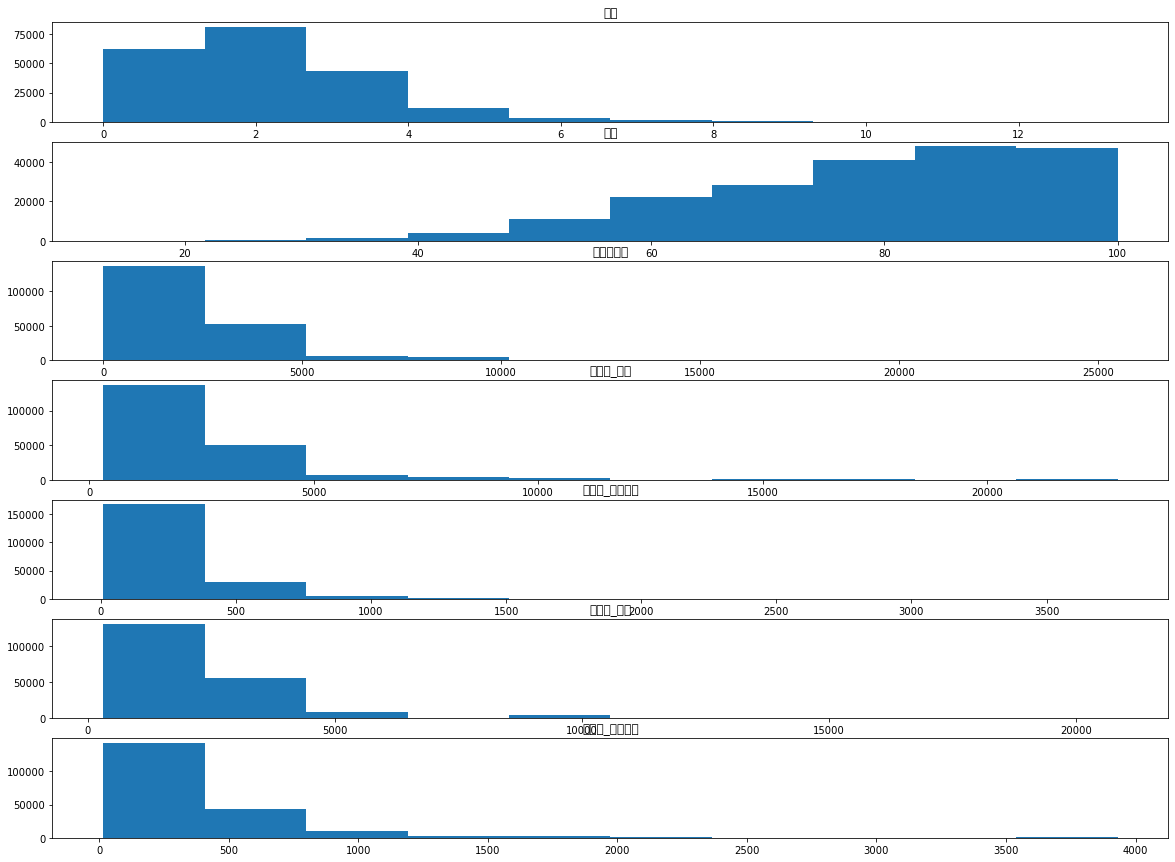

In [104]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(7,1)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(['풍속', '습도', '전력소비량', '요일별_평균', '요일별_표준편차', '시간별_평균', '시간별_표준편차']):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

In [105]:
train_df['log_풍속'] = np.log1p(train_df['풍속'])
train_df['log_전력소비량'] = np.log1p(train_df['전력소비량'])

train_df['log_요일별_평균'] = np.log1p(train_df['요일별_평균'])
train_df['log_요일별_표준편차'] = np.log1p(train_df['요일별_표준편차'])
train_df['log_시간별_평균'] = np.log1p(train_df['시간별_평균'])
train_df['log_시간별_표준편차'] = np.log1p(train_df['시간별_표준편차'])

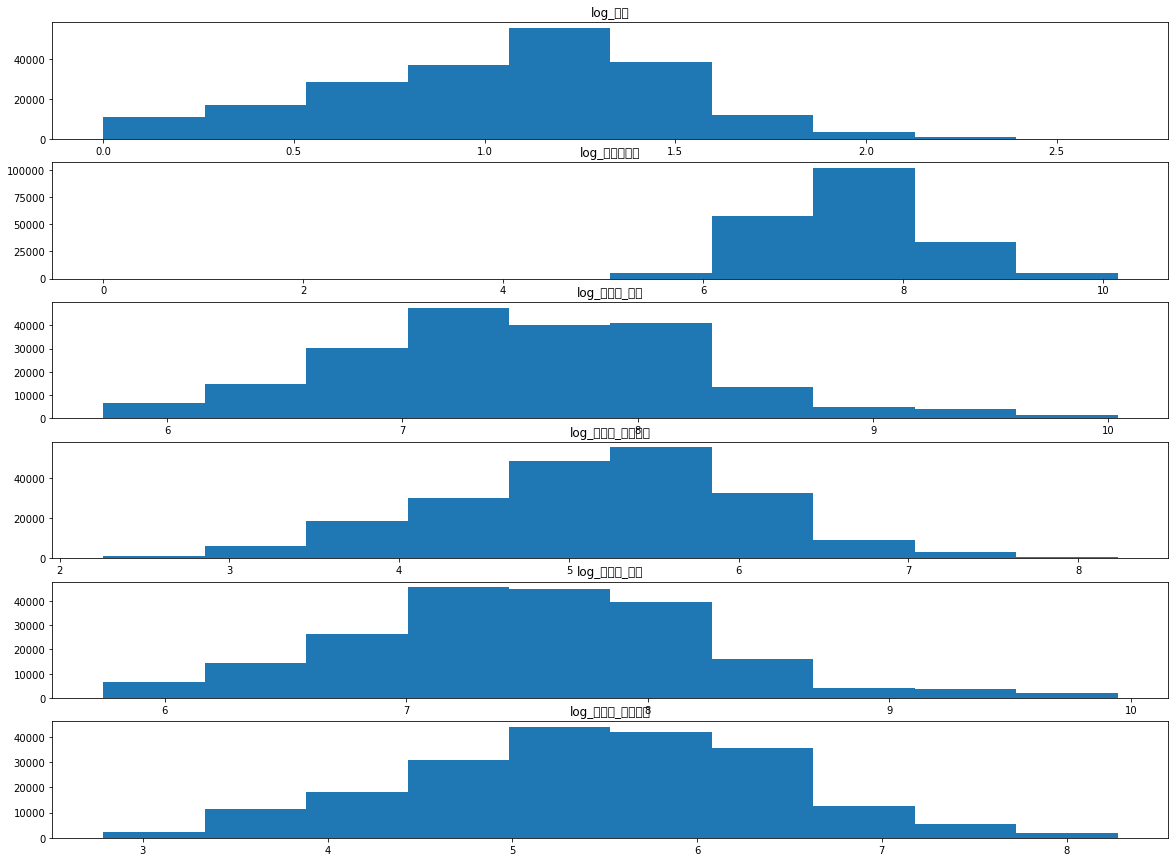

In [106]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(6,1)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(['log_풍속', 'log_전력소비량', 'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차']):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

In [107]:
train_df

,건물번호,기온,풍속,습도,전력소비량,일,날짜,sin_요일,cos_요일,sin_시간,...,열지수,체감온도,불쾌지수,CDH,log_풍속,log_전력소비량,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,1,18.6,0.9,42.0,1085.28,1,2022-06-01,0.866025,-0.5,0.000000e+00,...,78.408916,20.751584,63.09388,18.6,0.641854,6.990514,7.481975,6.251870,7.442679,6.104532
1,1,18.0,1.1,45.0,1047.36,1,2022-06-01,0.866025,-0.5,2.697968e-01,...,79.147251,20.008954,62.46400,18.0,0.741937,6.954982,7.431506,6.218142,7.392414,6.088280
2,1,17.7,1.5,45.0,974.88,1,2022-06-01,0.866025,-0.5,5.195840e-01,...,79.492837,19.476910,62.08735,17.7,0.916291,6.883340,7.360411,6.144674,7.318521,6.023622
3,1,16.7,1.4,48.0,953.76,1,2022-06-01,0.866025,-0.5,7.308360e-01,...,80.948219,18.487958,60.89884,16.7,0.875469,6.861460,7.328538,6.081308,7.271263,5.971787
4,1,18.4,2.8,43.0,986.40,1,2022-06-01,0.866025,-0.5,8.878852e-01,...,78.649811,19.751534,62.88788,18.4,1.335001,6.895075,7.318403,6.007628,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,24,2022-08-24,0.866025,-0.5,-8.878852e-01,...,72.567800,25.302757,72.38034,23.1,0.641854,6.782237,6.873033,5.104887,6.919152,5.090060
203996,100,22.4,1.3,86.0,798.96,24,2022-08-24,0.866025,-0.5,-7.308360e-01,...,70.929804,24.446518,71.21736,22.4,0.832909,6.684562,6.783534,5.037446,6.834243,4.931347
203997,100,21.3,1.0,92.0,825.12,24,2022-08-24,0.866025,-0.5,-5.195840e-01,...,66.382661,23.433400,69.79704,21.3,0.693147,6.716740,6.659416,4.972696,6.722669,4.862137
203998,100,21.0,0.3,94.0,640.08,24,2022-08-24,0.866025,-0.5,-2.697968e-01,...,64.810657,23.661275,69.41060,21.0,0.262364,6.463154,6.498685,4.664827,6.584930,4.731486


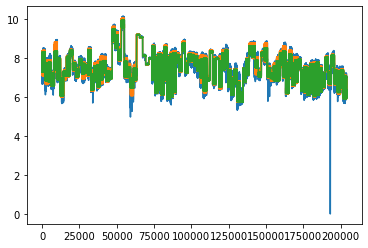

In [108]:
plt.plot(train_df[['log_전력소비량']])
plt.plot(train_df[['log_요일별_평균']])
plt.plot(train_df[['log_시간별_평균']])

In [109]:
train_df.columns

Index([        '건물번호',           '기온',           '풍속',           '습도',
              '전력소비량',            '일',           '날짜',       'sin_요일',
             'cos_요일',       'sin_시간',       'cos_시간',        'sin_일',
              'cos_일',           '휴일',              6,              7,
                    8,       '요일별_평균',     '요일별_표준편차',       '시간별_평균',
           '시간별_표준편차',          '열지수',         '체감온도',         '불쾌지수',
                'CDH',       'log_풍속',    'log_전력소비량',   'log_요일별_평균',
       'log_요일별_표준편차',   'log_시간별_평균', 'log_시간별_표준편차'],
      dtype='object')

In [111]:
train_df = train_df[['건물번호', 'log_전력소비량', '기온', '습도', 'sin_요일', 'cos_요일',
       'sin_시간', 'cos_시간', 'sin_일', 'cos_일', '휴일', '열지수', '체감온도', '불쾌지수', 'CDH', 'log_풍속',
       'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차', 6, 7, 8]]
train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호']==i])


In [112]:
for i in range(100):
    train_dfs[i] = train_dfs[i].drop(columns = ['건물번호'])

In [113]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [115]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [116]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [117]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time', '강수량(mm)'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도'})

## 일시 columns
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['월'] = test_df['일시'].dt.month
test_df['일'] = test_df['일시'].dt.day
test_df['요일'] = test_df['일시'].dt.weekday
test_df['시간'] = test_df['일시'].dt.hour
# test_df['날짜'] = test_df['일시'].dt.date

test_df['sin_요일'] = np.sin(2*np.pi*(test_df['요일'])/6)
test_df['cos_요일'] = np.cos(2*np.pi*(test_df['요일'])/6)
test_df['sin_시간'] = np.sin(2*np.pi*(test_df['시간'])/23)
test_df['cos_시간'] = np.cos(2*np.pi*(test_df['시간'])/23)
test_df['sin_일'] = np.sin(2*np.pi*(test_df['일']-1)/30)
test_df['cos_일'] = np.cos(2*np.pi*(test_df['일']-1)/30)

test_df['휴일'] = test_df['요일'].isin([5,6]).astype(int)

# 파생변수 생성 - 열지수
test_df['기온(F)'] = (test_df['기온'] * 9/5) + 32
T = test_df['기온(F)']
RH = test_df['습도']
test_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
# test_df['열지수'] = pd.cut(test_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])

# 파생변수 생성 - 체감온도
T = test_df['기온']
W = test_df['풍속']
test_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

# 파생변수 생성 - 불쾌지수
T = 9/5*test_df['기온']
RH = test_df['습도']
test_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
# test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])

# 파생변수 생성 - CDH

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df['log_풍속'] = np.log1p(test_df['풍속'])

# 전력소비량 넣어주기
test_df['요일별_평균'] = test_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)
test_df['요일별_표준편차'] = test_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_평균'] = test_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_표준편차'] = test_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

test_df['log_요일별_평균'] = np.log1p(test_df['요일별_평균'])
test_df['log_요일별_표준편차'] = np.log1p(test_df['요일별_표준편차'])
test_df['log_시간별_평균'] = np.log1p(test_df['시간별_평균'])
test_df['log_시간별_표준편차'] = np.log1p(test_df['시간별_표준편차'])

test_df[6] = 0
test_df[7] = 0
cat_month = pd.get_dummies(test_df['월'])
test_df = pd.concat([test_df, cat_month], axis = 1).drop(columns = ['월'])

100%|██████████| 16800/16800 [00:05<00:00, 3281.21it/s]


In [118]:
test_df[6] = test_df[6].astype('uint8')
test_df[7] = test_df[7].astype('uint8')

In [119]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   건물번호          16800 non-null  int64         
 1   일시            16800 non-null  datetime64[ns]
 2   기온            16800 non-null  float64       
 3   풍속            16800 non-null  float64       
 4   습도            16800 non-null  int64         
 5   일             16800 non-null  int64         
 6   요일            16800 non-null  int64         
 7   시간            16800 non-null  int64         
 8   sin_요일        16800 non-null  float64       
 9   cos_요일        16800 non-null  float64       
 10  sin_시간        16800 non-null  float64       
 11  cos_시간        16800 non-null  float64       
 12  sin_일         16800 non-null  float64       
 13  cos_일         16800 non-null  float64       
 14  휴일            16800 non-null  int32         
 15  기온(F)         16800 non-null  float6

In [120]:
test_df = test_df[['건물번호', '기온', '습도','sin_요일', 'cos_요일',
       'sin_시간', 'cos_시간', 'sin_일', 'cos_일', '휴일', '열지수', '체감온도', '불쾌지수', 'CDH', 'log_풍속',
       'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차', 6, 7, 8]]
test_input  = []
for i in range(1,101):
    test_input.append(test_df[test_df['건물번호']==i])

for i in range(100):
    test_input[i] = test_input[i].drop(columns = ['건물번호'])


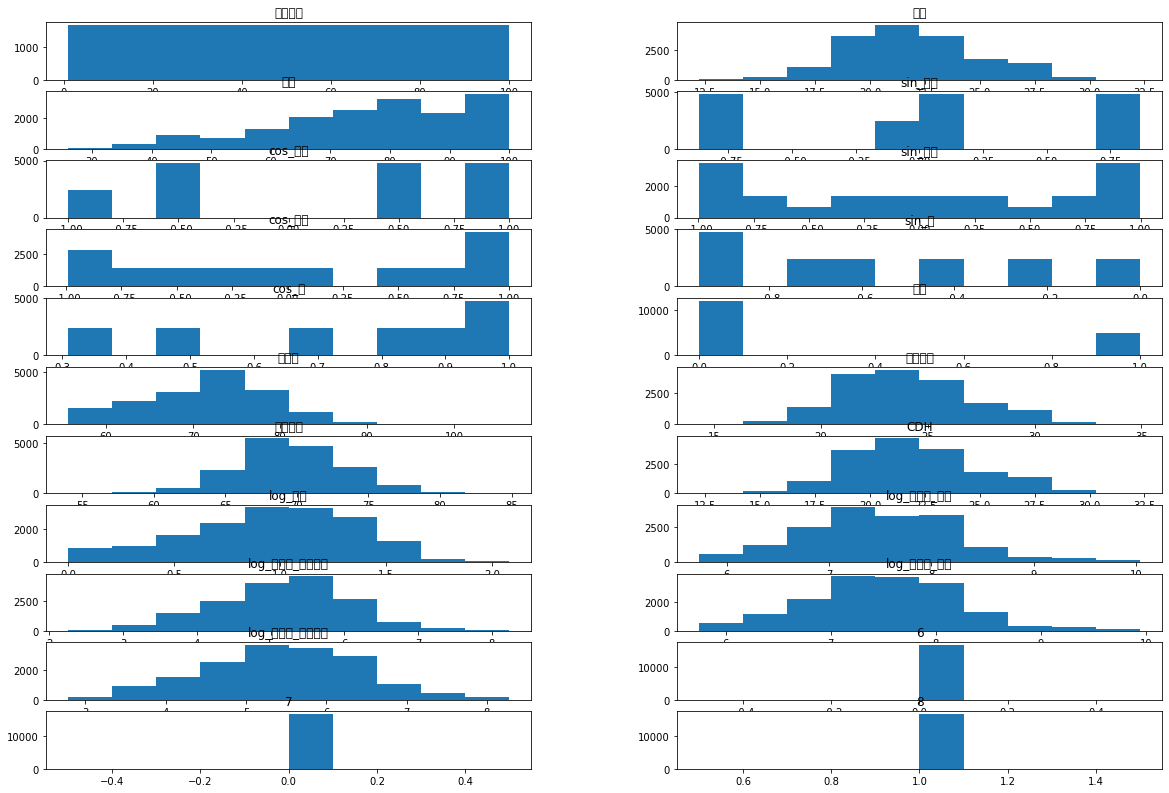

In [122]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(12,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(test_df.columns):
    ax = plt.subplot(grid[idx])
    plt.hist(test_df[feature])
    plt.title(f"{feature}")

In [123]:
display(train_input[0])
display(test_input[0])

,기온,습도,sin_요일,cos_요일,sin_시간,cos_시간,sin_일,cos_일,휴일,열지수,...,불쾌지수,CDH,log_풍속,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차,6,7,8
0,18.6,42.0,0.866025,-0.5,0.000000e+00,1.000000,0.000000,1.000000,0,78.408916,...,63.09388,18.6,0.641854,7.481975,6.251870,7.442679,6.104532,1,0,0
1,18.0,45.0,0.866025,-0.5,2.697968e-01,0.962917,0.000000,1.000000,0,79.147251,...,62.46400,18.0,0.741937,7.431506,6.218142,7.392414,6.088280,1,0,0
2,17.7,45.0,0.866025,-0.5,5.195840e-01,0.854419,0.000000,1.000000,0,79.492837,...,62.08735,17.7,0.916291,7.360411,6.144674,7.318521,6.023622,1,0,0
3,16.7,48.0,0.866025,-0.5,7.308360e-01,0.682553,0.000000,1.000000,0,80.948219,...,60.89884,16.7,0.875469,7.328538,6.081308,7.271263,5.971787,1,0,0
4,18.4,43.0,0.866025,-0.5,8.878852e-01,0.460065,0.000000,1.000000,0,78.649811,...,62.88788,18.4,1.335001,7.318403,6.007628,7.278161,5.945682,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,63.0,0.866025,-0.5,-8.878852e-01,0.460065,-0.994522,0.104528,0,79.681361,...,73.85035,25.5,1.360977,7.852622,5.950292,7.902810,5.936241,0,0,1
2036,25.0,66.0,0.866025,-0.5,-7.308360e-01,0.682553,-0.994522,0.104528,0,78.797002,...,73.44700,25.0,1.280934,7.779897,6.003982,7.821234,5.879386,0,0,1
2037,24.6,67.0,0.866025,-0.5,-5.195840e-01,0.854419,-0.994522,0.104528,0,78.058634,...,72.96218,24.6,0.832909,7.543777,5.492728,7.587466,5.383027,0,0,1
2038,24.1,70.0,0.866025,-0.5,-2.697968e-01,0.962917,-0.994522,0.104528,0,77.031069,...,72.51230,24.1,1.131402,7.254080,4.662324,7.295769,4.753586,0,0,1


,기온,습도,sin_요일,cos_요일,sin_시간,cos_시간,sin_일,cos_일,휴일,열지수,...,불쾌지수,CDH,log_풍속,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차,6,7,8
0,23.5,72,1.224647e-16,-1.0,0.000000e+00,1.000000,-9.510565e-01,0.309017,0,75.835980,...,71.78980,23.5,1.163151,7.395599,6.104760,7.442679,6.104532,0,0,1
1,23.0,72,1.224647e-16,-1.0,2.697968e-01,0.962917,-9.510565e-01,0.309017,0,75.097159,...,71.02840,23.0,0.641854,7.346707,6.109451,7.392414,6.088280,0,0,1
2,22.7,75,1.224647e-16,-1.0,5.195840e-01,0.854419,-9.510565e-01,0.309017,0,74.149922,...,70.81675,22.7,0.916291,7.266911,6.031775,7.318521,6.023622,0,0,1
3,22.1,78,1.224647e-16,-1.0,7.308360e-01,0.682553,-9.510565e-01,0.309017,0,72.636805,...,70.11262,22.1,0.832909,7.224899,5.937847,7.271263,5.971787,0,0,1
4,21.8,77,1.224647e-16,-1.0,8.878852e-01,0.460065,-9.510565e-01,0.309017,0,72.533716,...,69.56514,21.8,0.693147,7.231808,5.889843,7.278161,5.945682,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,75,8.660254e-01,-0.5,-8.878852e-01,0.460065,-1.133108e-15,1.000000,0,75.442391,...,72.05875,23.5,1.098612,7.852622,5.950292,7.902810,5.936241,0,0,1
164,22.4,80,8.660254e-01,-0.5,-7.308360e-01,0.682553,-1.133108e-15,1.000000,0,72.571571,...,70.74480,22.4,1.098612,7.779897,6.003982,7.821234,5.879386,0,0,1
165,21.7,81,8.660254e-01,-0.5,-5.195840e-01,0.854419,-1.133108e-15,1.000000,0,71.235792,...,69.69523,21.7,0.955511,7.543777,5.492728,7.587466,5.383027,0,0,1
166,21.1,83,8.660254e-01,-0.5,-2.697968e-01,0.962917,-1.133108e-15,1.000000,0,69.774703,...,68.85987,21.1,0.693147,7.254080,4.662324,7.295769,4.753586,0,0,1


In [141]:
submission = pd.read_csv('../dataset/sample_submission.csv')

In [142]:
random_seed = 42
K = [i for i in [5]]
# catfeatures = ['월', '휴일', '불쾌지수', '열지수']

# cat_mae_params = {
#     'objective': 'MAE',
#     'n_estimators': 10000,
#     'early_stopping_rounds': 4, 
#     'cat_features' : catfeatures,
#     'one_hot_max_size' : 5
# } # catboost hyper parameter

# lgbm_mae_params = {
#     'objective': 'MAE',
#     'boosting_type': 'goss',
#     'n_estimators': 10000,
#     'early_stopping_round': 15, 
#     'num_leaves':39,
#     'categorical_feature = name' : catfeatures
# } # lightgbm hyper parameter

xgboost_params = {
    'objective':'reg:linear',
    'eval_metric' : 'rmse',
    'n_estimators':1000,
    'seed':random_seed,
    'min_child_weight':1,
    'eta':0.3,
    'gamma':0,
    'max_depth':6,
    'sub_sample':1,
    'colsample_bytree' : 1,
    'lambda':1,
    'alpha':0,
    'scale_pos_weight':1
}

for k in K: # kfold 의 nspilt 의 값 k
    folds = []
    for i in range(len(train_dfs)):
        cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
        fold = []
        for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
            fold.append((train_idx, valid_idx))
        folds.append(fold)
            
    for i in range(len(train_dfs)):
        for fold in range(k):
            print(random_seed, k, i)
            train_idx, valid_idx = folds[i][fold]
            X_train = train_input[i].iloc[train_idx]
            y_train = train_target[i].iloc[train_idx]
            X_valid = train_input[i].iloc[valid_idx]
            y_valid = train_target[i].iloc[valid_idx]                
            # catboost 학습 
            # model = CatBoostRegressor(**cat_mae_params)
            # model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            # v = (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 1
                
            #lgbm 학습 
            # model=LGBMRegressor(**lgbm_mae_params)
            # model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
            # v = (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 1
            
            # xgboost 학습
            model = XGBRegressor(**xgboost_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            v = (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 1
    
            submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k)
            clear_output(True)

42 5 99
[15:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

[0]	validation_0-rmse:4.31910
[1]	validation_0-rmse:3.03172
[2]	validation_0-rmse:2.12534
[3]	validation_0-rmse:1.49241
[4]	validation_0-rmse:1.05062
[5]	validation_0-rmse:0.74070
[6]	validation_0-rmse:0.52482
[7]	validation_0-rmse:0.37505
[8]	validation_0-rmse:0.27092
[9]	validation_0-rmse:0.19970
[10]	validation_0-rmse:0.15327
[11]	validation_0-rmse:0.12093
[12]	validation_0-rmse:0.10222
[13]	validation_0-rmse:0.09093
[14]	validation_0-rmse:0.08383
[15]	validation_0-rmse:0.08057
[16]	validation_0-rmse:0.07880
[17]	validation_0-rmse:0.07790
[18]	validati

In [143]:
submission

,num_date_time,answer
0,1_20220825 00,2038.643738
1,1_20220825 01,1974.402954
2,1_20220825 02,1744.126099
3,1_20220825 03,1560.389130
4,1_20220825 04,1600.776733
...,...,...
16795,100_20220831 19,945.136520
16796,100_20220831 20,820.907761
16797,100_20220831 21,730.127701
16798,100_20220831 22,601.146713


In [144]:
submission.to_csv('../submission/answer13.csv', index = False) # 파일 저장

In [146]:
best = pd.read_csv('../submission/answer12.csv')
update = pd.read_csv('../submission/answer13.csv')

In [150]:
display(best)
display(update)

,num_date_time,answer
0,1_20220825 00,1964.406297
1,1_20220825 01,1868.603542
2,1_20220825 02,1698.213004
3,1_20220825 03,1611.891991
4,1_20220825 04,1608.727523
...,...,...
16795,100_20220831 19,959.004612
16796,100_20220831 20,864.906644
16797,100_20220831 21,771.612402
16798,100_20220831 22,676.423301


,num_date_time,answer
0,1_20220825 00,2038.643738
1,1_20220825 01,1974.402954
2,1_20220825 02,1744.126099
3,1_20220825 03,1560.389130
4,1_20220825 04,1600.776733
...,...,...
16795,100_20220831 19,945.136520
16796,100_20220831 20,820.907761
16797,100_20220831 21,730.127701
16798,100_20220831 22,601.146713


In [ ]:
x = np.array(best['num_date_time'])
y = np.array(best['answer'])


x_ = np.array(update['num_date_time'])
y_ = np.array(update['answer'])

plt.figure(figsize = (30, 15))
plt.plot(x, y)
plt.plot(x_, y_)

Error in callback <function flush_figures at 0x00000259AC4688B0> (for post_execute):


KeyboardInterrupt: 